In [30]:
"""
NLP from scratch: Classifying names with a character-level RNN and LSTM
"""


from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import torch
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random

print('Done')

Done


In [31]:
"""
Step 1. Preparing the data
"""

def findFiles(path): 
    return glob.glob(path)

path = '/home/song/Downloads/Project3_code_and_data/data/names/'
print(findFiles(path+'*.txt'))

['/home/song/Downloads/Project3_code_and_data/data/names/Chinese.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Portuguese.txt', '/home/song/Downloads/Project3_code_and_data/data/names/German.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Czech.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Korean.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Dutch.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Arabic.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Greek.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Japanese.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Irish.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Russian.txt', '/home/song/Downloads/Project3_code_and_data/data/names/French.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Polish.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Spanish.txt', '/home/song/Downloads/Projec

In [32]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

#  Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

#  Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

#  Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(path+'*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)

#  Now we have category_lines, a dictionary mapping each category (language) to a 
#list of lines (names). We also kept track of all_categories (just a list of 
#languages) and n_categories for later reference.


Slusarski
18


In [4]:
"""
Step 2. Turning names into tensors
"""
#  Now that we have all names organized, we need to turn them into Tensors to make 
#any use of them. To represent a single letter, we use a ``one-hot vector'' of size 
#<1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the 
#current letter, e.g. "b" = <0 1 0 0 0 ...>
#  To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>
#The extra 1 dimension is because PyTorch assumes everything is in batches -- we're
#just using a batch size of 1 here.
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [7]:

"""
Step 3. Creating the Network
"""

class MomentumRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, momentum=0.5):
        super(MomentumRNN, self).__init__()

        self.hidden_size = hidden_size
        self.momentum = momentum

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        self.hidden = None
        self.delta_i2h = 0
        self.delta_i2o = 0

    def forward(self, input):
        combined = torch.cat((input, self.hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        self.hidden = hidden

        return output

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    def update_weights(self, learning_rate):
        with torch.no_grad():
            self.delta_i2h = self.momentum * self.delta_i2h + learning_rate * self.i2h.weight.grad
            self.delta_i2o = self.momentum * self.delta_i2o + learning_rate * self.i2o.weight.grad

            self.i2h.weight -= self.delta_i2h
            self.i2o.weight -= self.delta_i2o

            self.i2h.bias -= learning_rate * self.i2h.bias.grad
            self.i2o.bias -= learning_rate * self.i2o.bias.grad



5000 5% (0m 6s) 2.5439 Kase / Chinese ✗ (Japanese)
10000 10% (0m 11s) 3.2954 Isa / Chinese ✗ (Arabic)
15000 15% (0m 17s) 1.3315 Flann / Irish ✓
20000 20% (0m 22s) 2.7305 Duarte / Italian ✗ (Portuguese)
25000 25% (0m 27s) 0.1428 Jaskulski / Polish ✓
30000 30% (0m 32s) 1.7198 Houtem / Polish ✗ (Dutch)
35000 35% (0m 37s) 2.4529 Kromberg / Dutch ✗ (English)
40000 40% (0m 42s) 1.0834 Luo / Vietnamese ✗ (Chinese)
45000 45% (0m 49s) 0.5738 Hubiev / Russian ✓
50000 50% (0m 54s) 1.3963 Mifsud / Arabic ✓
55000 55% (0m 59s) 0.0466 Vuong / Vietnamese ✓
60000 60% (1m 5s) 0.1876 Cunningham / Scottish ✓
65000 65% (1m 10s) 2.0549 Snaaijer / German ✗ (Dutch)
70000 70% (1m 15s) 1.1243 Pena / Spanish ✓
75000 75% (1m 20s) 0.1078 Roggeveen / Dutch ✓
80000 80% (1m 25s) 1.3983 Ina / Japanese ✓
85000 85% (1m 30s) 0.3360 Tron / Vietnamese ✓
90000 90% (1m 35s) 1.6228 Thirlway / Scottish ✗ (English)
95000 95% (1m 41s) 2.8058 Aodha / Arabic ✗ (Irish)
100000 100% (1m 46s) 0.5131 Hawley / English ✓


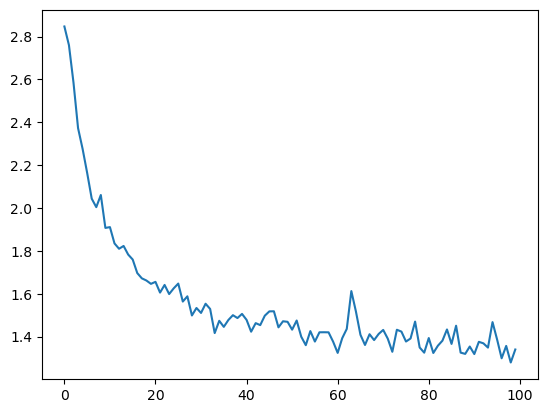

In [15]:
"""
Step 4. Training
"""

def train(category_tensor, line_tensor):
    rnn.zero_grad()
    rnn.hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output = rnn(line_tensor[i])

    loss = criterion(output, category_tensor)
    loss.backward()

    rnn.update_weights(learning_rate)

    return output, loss.item()
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


n_hidden = 128
rnn = MomentumRNN(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()
learning_rate = 0.005
n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

plt.figure()
plt.plot(all_losses)
plt.show()

## To implement MomentumRNN for the character-level RNN task, you can modify the existing RNN code. The MomentumRNN is a variant of the basic RNN that incorporates momentum optimization during training to accelerate convergence.

Here's the modified code to implement MomentumRNN:

## MomentumRNN

In [44]:
"""
Step 3. Creating the Network MomentumRNN
"""
import torch.nn.init as init

class MomentumRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MomentumRNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        # Initialize momentum variables
        self.momentum_i2h = torch.zeros(self.i2h.weight.data.shape)
        self.momentum_i2o = torch.zeros(self.i2o.weight.data.shape)

        # Initialize weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
momentum_rnn = MomentumRNN(n_letters, n_hidden, n_categories)


5000 5% (0m 5s) 0.9307 Groel / German ✓
10000 10% (0m 11s) 0.2297 Hew / Chinese ✓
15000 15% (0m 16s) 0.0054 Pham / Vietnamese ✓
20000 20% (0m 22s) 2.7355 Porcher / Greek ✗ (French)
25000 25% (0m 27s) 0.0276 Koyama / Japanese ✓
30000 30% (0m 33s) 0.0385 Patrianakos / Greek ✓
35000 35% (0m 38s) 0.6963 Parodi / Italian ✓
40000 40% (0m 44s) 0.0695 Ku / Korean ✓
45000 45% (0m 49s) 1.8378 Koci / Japanese ✗ (Czech)
50000 50% (0m 55s) 0.0373 Haddad / Arabic ✓
55000 55% (1m 1s) 0.7843 Allan / Scottish ✓
60000 60% (1m 6s) 2.9663 Aquino / Italian ✗ (Spanish)
65000 65% (1m 12s) 2.1653 Pae / Vietnamese ✗ (Korean)
70000 70% (1m 17s) 0.9791 Mashita / Japanese ✓
75000 75% (1m 23s) 3.1008 Peters / Dutch ✗ (German)
80000 80% (1m 28s) 4.7728 Dovgopoly / Italian ✗ (Russian)
85000 85% (1m 34s) 0.8280 Fugunaga / Japanese ✓
90000 90% (1m 39s) 0.0858 Nomikos / Greek ✓
95000 95% (1m 45s) 0.0023 Mozdzierz / Polish ✓
100000 100% (1m 50s) 0.0887 Melo / Portuguese ✓


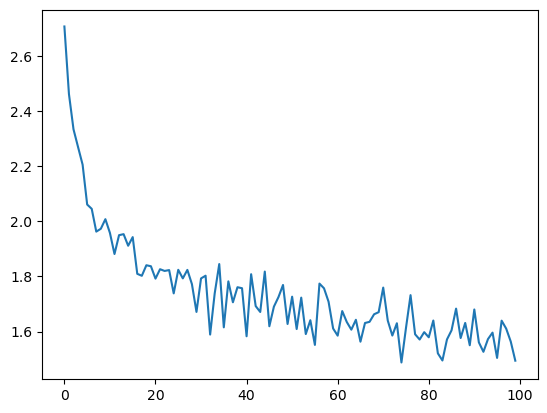

In [45]:
"""
Step 4. Training
"""
# Define the optimizer with momentum
optimizer = optim.SGD(momentum_rnn.parameters(), lr=learning_rate, momentum=0.9)

# Training loop with momentum optimization
def train_momentum(category_tensor, line_tensor):
    momentum_rnn.zero_grad()

    hidden = momentum_rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = momentum_rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Apply gradient clipping
    torch.nn.utils.clip_grad_norm_(momentum_rnn.parameters(), max_norm=1.0)

    optimizer.step()

    return output, loss.item()

# Training the MomentumRNN
momentum_losses = []
current_loss = 0
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_momentum(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        momentum_losses.append(current_loss / plot_every)
        current_loss = 0

plt.figure()
plt.plot(momentum_losses)


/tmp/ipykernel_7642/1035395122.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_7642/1035395122.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


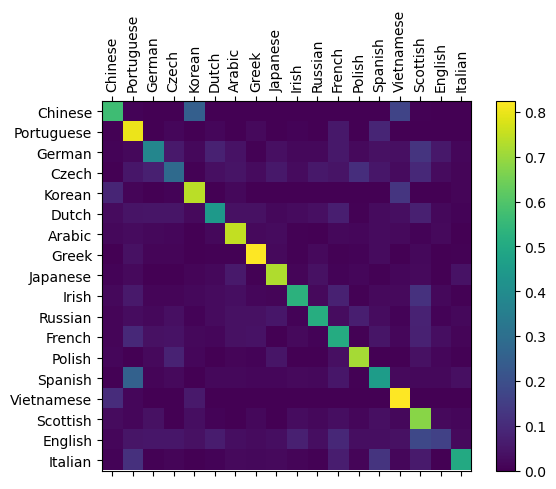

In [48]:
"""
Step 5. Evaluating the results
"""
# Evaluating the network and create a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = momentum_rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = momentum_rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


In [49]:

"""
Step 5.1: Running on User input
"""
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

# Make predictions for user input
predict('Yuan')
predict('Jackson')
predict('Satoshi')



> Yuan
(-0.50) Korean
(-0.96) Chinese
(-5.75) Vietnamese

> Jackson
(-0.00) Scottish
(-7.44) Russian
(-7.64) English

> Satoshi
(-0.44) Portuguese
(-2.27) Czech
(-3.02) Greek


## RNN

In [50]:
"""
Step 3. Creating the Network RNN
"""
#  Before autograd, creating a recurrent neural network in PyTorch involved cloning
#the parameters of a layer over several timesteps. The layer held hidden state and 
#gradients which are now entirely handled by the graph itself.

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

#  To run a step of this network we need to pass an input (in our case, the Tensor
#for the current letter) and a previous hidden state (which we initialize as zeros
#at first). We'll get back the output (probability of each language) and a next
#hidden state (which we keep for next step).
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

#  As you can see the output is a <1 x n_category> Tensor, where every item is the
#likelihood of that category (higher is more likely).

tensor([[-2.9654, -2.8841, -2.7834, -2.9455, -2.8918, -2.8541, -2.8561, -2.8425,
         -2.8720, -2.8392, -2.8934, -2.8591, -2.9335, -2.9058, -2.9536, -2.8861,
         -2.8801, -3.0051]], grad_fn=<LogSoftmaxBackward0>)


('German', 2)
category = Russian / line = Vaigant
category = Russian / line = Gatturov
category = Portuguese / line = Mateus
category = Spanish / line = De santigo
category = Arabic / line = Almasi
category = Polish / line = Rog
category = Arabic / line = Atiyeh
category = German / line = Leitzke
category = Dutch / line = Seegers
category = Greek / line = Bilias


/tmp/ipykernel_7642/3070653463.py:54: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484746364/work/torch/csrc/utils/python_arg_parser.cpp:1174.)
  p.data.add_(-learning_rate, p.grad.data)


5000 5% (0m 5s) 2.2803 Ferreira / Russian ✗ (Portuguese)
10000 10% (0m 11s) 2.4798 Daele / French ✗ (Dutch)
15000 15% (0m 16s) 0.9745 Shim / Korean ✓
20000 20% (0m 20s) 1.0545 Huan / Chinese ✓
25000 25% (0m 25s) 2.4270 Rosenfeld / French ✗ (German)
30000 30% (0m 29s) 0.5660 Calpis / Greek ✓
35000 35% (0m 33s) 0.8672 Pham / Vietnamese ✓
40000 40% (0m 38s) 0.9881 Anley / English ✓
45000 45% (0m 42s) 0.4237 Dao / Vietnamese ✓
50000 50% (0m 47s) 0.4675 Kouros / Greek ✓
55000 55% (0m 52s) 0.6706 Kau / Chinese ✓
60000 60% (0m 56s) 1.1880 Klerken / Dutch ✓
65000 65% (1m 1s) 0.2765 Gui / Chinese ✓
70000 70% (1m 5s) 1.7344 Marion / Irish ✗ (French)
75000 75% (1m 10s) 1.8593 Abelyan / Scottish ✗ (Russian)
80000 80% (1m 14s) 3.4098 Aarle / Portuguese ✗ (Dutch)
85000 85% (1m 19s) 0.6492 Bermudez / Spanish ✓
90000 90% (1m 24s) 2.4733 Yang / Korean ✗ (Chinese)
95000 95% (1m 31s) 0.3694 Ku / Korean ✓
100000 100% (1m 36s) 0.7327 Pho / Vietnamese ✓


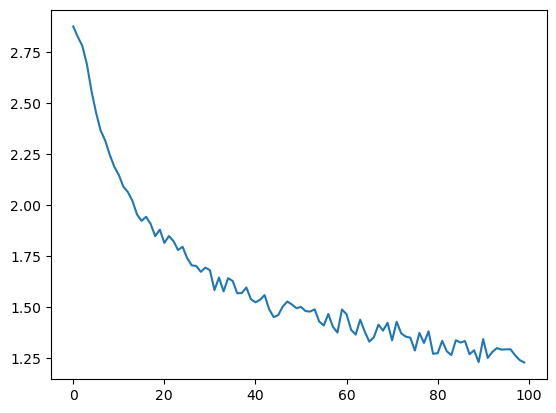

In [51]:
"""
Step 4. Training RNN
"""

#  Before going into training we should make a few helper functions. The first is
#to interpret the output of the network, which we know to be a likelihood of each
#category. We can use Tensor.topk to get the index of the greatest value.
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))


#  We will also want a quick way to get a training example (a name and its language):
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

#  Now all it takes to train this network is show it a bunch of examples, have it
#make guesses, and tell it if it's wrong.
#  For the loss, nn.NLLLoss is appropriate since the last layer of the RNN is 
#nn.LogSoftmax.
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()


#  Now we just have to run with a bunch of examples. Since the train function returns
#both the output and loss we can print its guesses and also keep track of loss for
#plotting. Since there are 1000s of examples we print only every print_every examples,
#and take an average of the loss.
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


#  Plotting the historical loss from all_losses shows the network learning:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_7642/2731588864.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_7642/2731588864.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


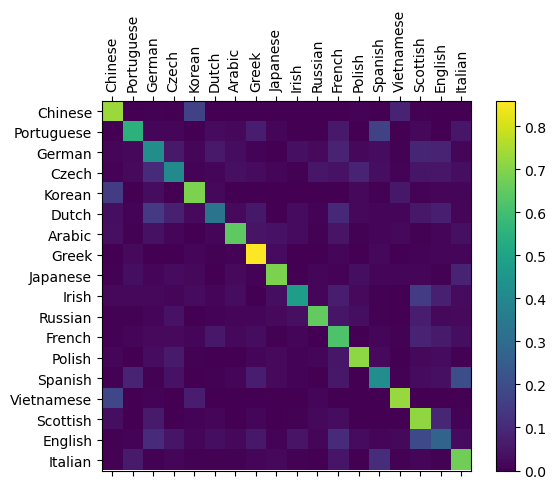

In [52]:
"""
Step 5. Evaluating the results RNN
"""

#  To see how well the network performs on different categories, we will create a confusion
#matrix, indicating for every actual language (rows) which language the network guesses
#(columns). To calculate the confusion matrix a bunch of samples are run through the
#network with evaluate(), which is the same as train() minus the backprop.
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [53]:

"""
Step 5.1: Running on User input
"""
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Yuan')
predict('Jackson')
predict('Satoshi')


> Yuan
(-0.36) Chinese
(-1.54) Korean
(-4.00) English

> Jackson
(-0.17) Scottish
(-2.22) English
(-4.06) Greek

> Satoshi
(-1.11) Italian
(-1.34) Japanese
(-2.08) Arabic


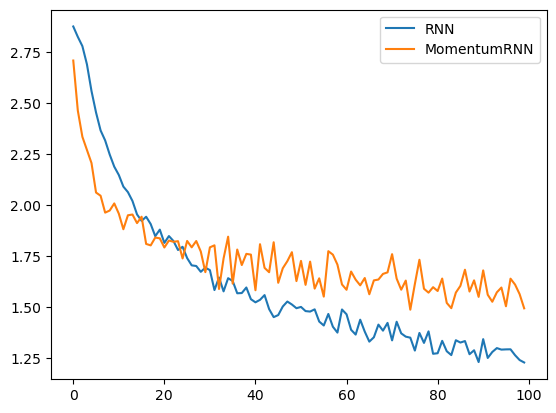

In [54]:
plt.figure()
plt.plot(all_losses, label='RNN')
plt.plot(momentum_losses, label='MomentumRNN')
plt.legend()
plt.show()

In [59]:
# Evaluate the performance of RNN and MomentumRNN
def evaluate_performance(model):
    # Initialize confusion matrix
    confusion = torch.zeros(n_categories, n_categories)

    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output = evaluate(line_tensor)  # Corrected line
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return confusion

# Evaluate performance of RNN
rnn_confusion = evaluate_performance(rnn)

# Evaluate performance of MomentumRNN
momentum_rnn_confusion = evaluate_performance(momentum_rnn)

# Print the confusion matrices
print("Confusion Matrix for RNN:")
print(rnn_confusion.numpy())

print("Confusion Matrix for MomentumRNN:")
print(momentum_rnn_confusion.numpy())


Confusion Matrix for RNN:
[[0.77504724 0.         0.01134215 0.         0.13610587 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.06994329 0.00756144 0.         0.        ]
 [0.         0.5711538  0.025      0.01153846 0.         0.01346154
  0.02307692 0.06923077 0.01346154 0.         0.         0.05192308
  0.         0.13846155 0.         0.01538462 0.         0.0673077 ]
 [0.01333333 0.00952381 0.4857143  0.04761905 0.01904762 0.07809523
  0.01714286 0.01142857 0.00190476 0.02285714 0.02095238 0.06857143
  0.00761905 0.00952381 0.01142857 0.0952381  0.07047619 0.00952381]
 [0.02737226 0.01459854 0.09124088 0.35036495 0.01824817 0.01824817
  0.0109489  0.02372263 0.02007299 0.         0.03832117 0.05109489
  0.12956205 0.03832117 0.00364964 0.07664233 0.05291971 0.03467153]
 [0.14285715 0.         0.01964286 0.         0.7107143  0.01428571
  0.         0.         0.         0.         0.         0.
  0.01785714 0.01428571 0.04464286 0.00892

In [60]:
# Calculate accuracy from confusion matrix
def calculate_accuracy(confusion_matrix):
    correct = 0
    total = confusion_matrix.sum()
    for i in range(n_categories):
        correct += confusion_matrix[i][i]
    accuracy = correct / total
    return accuracy

# Calculate accuracy for RNN
rnn_accuracy = calculate_accuracy(rnn_confusion)

# Calculate accuracy for MomentumRNN
momentum_rnn_accuracy = calculate_accuracy(momentum_rnn_confusion)

# Print the accuracies
print("Accuracy for RNN: {:.2%}".format(rnn_accuracy))
print("Accuracy for MomentumRNN: {:.2%}".format(momentum_rnn_accuracy))


Accuracy for RNN: 59.35%
Accuracy for MomentumRNN: 59.29%


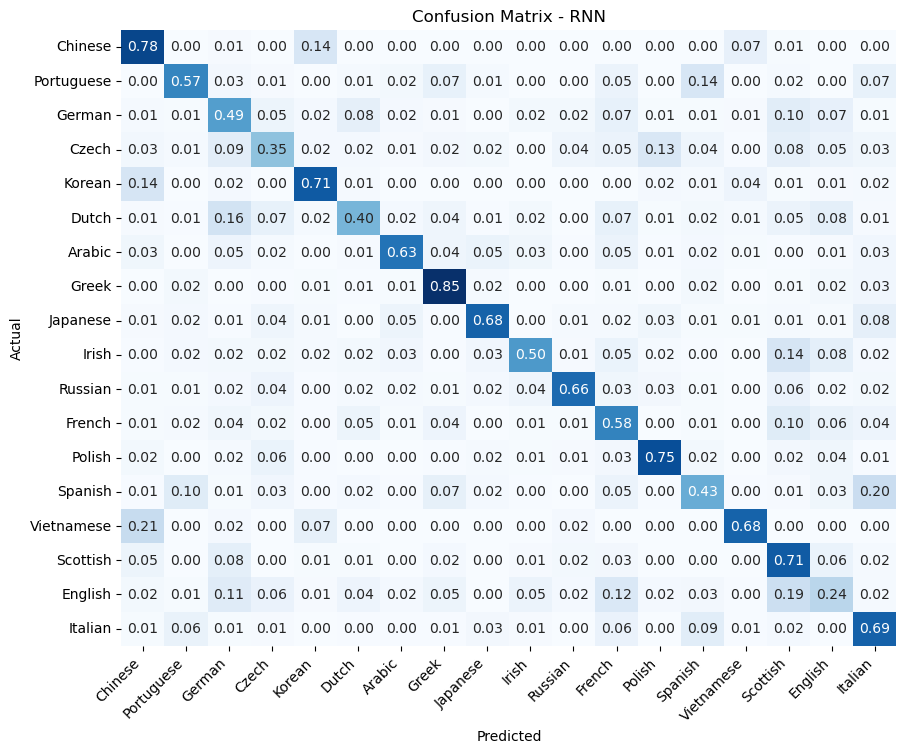

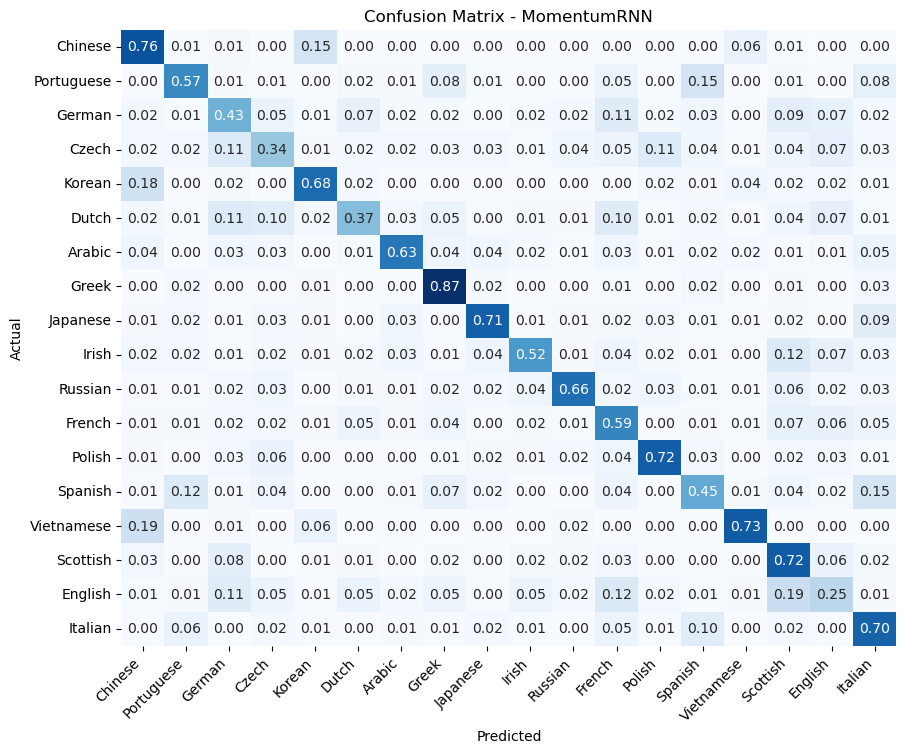

Recalls for RNN:
Chinese: 77.50%
Portuguese: 57.12%
German: 48.57%
Czech: 35.04%
Korean: 71.07%
Dutch: 39.75%
Arabic: 62.67%
Greek: 84.72%
Japanese: 68.35%
Irish: 50.27%
Russian: 65.68%
French: 57.69%
Polish: 75.04%
Spanish: 43.19%
Vietnamese: 68.11%
Scottish: 70.53%
English: 24.39%
Italian: 68.56%

Recalls for MomentumRNN:
Chinese: 75.64%
Portuguese: 56.91%
German: 42.54%
Czech: 33.77%
Korean: 67.57%
Dutch: 37.40%
Arabic: 62.92%
Greek: 87.04%
Japanese: 70.86%
Irish: 51.76%
Russian: 65.93%
French: 58.52%
Polish: 71.82%
Spanish: 45.44%
Vietnamese: 72.61%
Scottish: 72.22%
English: 24.51%
Italian: 69.71%


In [61]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to draw the confusion matrix
def draw_confusion_matrix(confusion_matrix, model_name):
    # Normalize the confusion matrix
    confusion_matrix_normalized = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 8))

    # Use seaborn to plot the confusion matrix heatmap
    sns.heatmap(confusion_matrix_normalized.numpy(), annot=True, fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=all_categories, yticklabels=all_categories, ax=ax)

    # Set the axis labels and title
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix - " + model_name)

    # Rotate the x-axis labels for better visibility
    plt.xticks(rotation=45, ha="right")

    # Show the plot
    plt.show()

# Draw confusion matrix for RNN
draw_confusion_matrix(rnn_confusion, "RNN")

# Draw confusion matrix for MomentumRNN
draw_confusion_matrix(momentum_rnn_confusion, "MomentumRNN")

# Calculate recall for each category
def calculate_recall(confusion_matrix):
    recalls = []
    for i in range(n_categories):
        recall = confusion_matrix[i][i] / confusion_matrix[i].sum()
        recalls.append(recall)
    return recalls

# Calculate recall for RNN
rnn_recalls = calculate_recall(rnn_confusion)

# Calculate recall for MomentumRNN
momentum_rnn_recalls = calculate_recall(momentum_rnn_confusion)

# Print the recalls
print("Recalls for RNN:")
for i, recall in enumerate(rnn_recalls):
    print("{}: {:.2%}".format(all_categories[i], recall))

print("\nRecalls for MomentumRNN:")
for i, recall in enumerate(momentum_rnn_recalls):
    print("{}: {:.2%}".format(all_categories[i], recall))


In [62]:
from sklearn.metrics import classification_report, accuracy_score

# Convert the confusion matrices to numpy arrays
rnn_confusion_np = rnn_confusion.numpy()
momentum_rnn_confusion_np = momentum_rnn_confusion.numpy()

# Flatten the confusion matrices
rnn_preds = rnn_confusion_np.argmax(axis=1)
rnn_targets = np.arange(len(all_categories))

momentum_rnn_preds = momentum_rnn_confusion_np.argmax(axis=1)
momentum_rnn_targets = np.arange(len(all_categories))

# Calculate accuracy score
rnn_accuracy = accuracy_score(rnn_targets, rnn_preds)
momentum_rnn_accuracy = accuracy_score(momentum_rnn_targets, momentum_rnn_preds)

# Calculate classification report
rnn_classification_report = classification_report(rnn_targets, rnn_preds, target_names=all_categories)
momentum_rnn_classification_report = classification_report(momentum_rnn_targets, momentum_rnn_preds, target_names=all_categories)

# Print the accuracy scores
print("Accuracy Score for RNN: {:.2%}".format(rnn_accuracy))
print("Accuracy Score for MomentumRNN: {:.2%}".format(momentum_rnn_accuracy))

# Print the classification reports
print("Classification Report for RNN:")
print(rnn_classification_report)

print("Classification Report for MomentumRNN:")
print(momentum_rnn_classification_report)


Accuracy Score for RNN: 100.00%
Accuracy Score for MomentumRNN: 100.00%
Classification Report for RNN:
              precision    recall  f1-score   support

     Chinese       1.00      1.00      1.00         1
  Portuguese       1.00      1.00      1.00         1
      German       1.00      1.00      1.00         1
       Czech       1.00      1.00      1.00         1
      Korean       1.00      1.00      1.00         1
       Dutch       1.00      1.00      1.00         1
      Arabic       1.00      1.00      1.00         1
       Greek       1.00      1.00      1.00         1
    Japanese       1.00      1.00      1.00         1
       Irish       1.00      1.00      1.00         1
     Russian       1.00      1.00      1.00         1
      French       1.00      1.00      1.00         1
      Polish       1.00      1.00      1.00         1
     Spanish       1.00      1.00      1.00         1
  Vietnamese       1.00      1.00      1.00         1
    Scottish       1.00      1.0

In [64]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluation function for RNN
def evaluate_rnn(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Evaluation function for MomentumRNN
def evaluate_momentum_rnn(line_tensor):
    hidden = momentum_rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = momentum_rnn(line_tensor[i], hidden)

    return output

# Lists to store predicted and true labels
predicted_rnn = []
predicted_momentum_rnn = []
true_labels = []
true_labels_momentum = [] 

# Evaluation loop for RNN
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_rnn = evaluate_rnn(line_tensor)
    guess_rnn, _ = categoryFromOutput(output_rnn)
    predicted_rnn.append(guess_rnn)
    true_labels.append(category)

# Evaluation loop for MomentumRNN
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_momentum_rnn = evaluate_momentum_rnn(line_tensor)
    guess_momentum_rnn, _ = categoryFromOutput(output_momentum_rnn)
    predicted_momentum_rnn.append(guess_momentum_rnn)
    true_labels_momentum.append(category)

# Print classification report and accuracy for RNN
print("RNN Performance:")
print(classification_report(true_labels, predicted_rnn))
print("Accuracy:", accuracy_score(true_labels, predicted_rnn))

# Print classification report and accuracy for MomentumRNN
print("MomentumRNN Performance:")
print(classification_report(true_labels_momentum, predicted_momentum_rnn))
print("Accuracy:", accuracy_score(true_labels_momentum, predicted_momentum_rnn))


RNN Performance:
              precision    recall  f1-score   support

      Arabic       0.70      0.59      0.64       591
     Chinese       0.60      0.75      0.67       560
       Czech       0.45      0.37      0.41       541
       Dutch       0.56      0.34      0.42       569
     English       0.31      0.25      0.27       572
      French       0.45      0.60      0.51       551
      German       0.43      0.43      0.43       556
       Greek       0.68      0.86      0.76       551
       Irish       0.72      0.51      0.60       551
     Italian       0.53      0.69      0.60       535
    Japanese       0.77      0.66      0.71       570
      Korean       0.66      0.69      0.68       532
      Polish       0.71      0.74      0.73       530
  Portuguese       0.67      0.59      0.63       565
     Russian       0.78      0.66      0.72       526
    Scottish       0.49      0.72      0.58       590
     Spanish       0.49      0.44      0.46       564
  Vietname

## above

/tmp/ipykernel_7642/3712567773.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_7642/3712567773.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


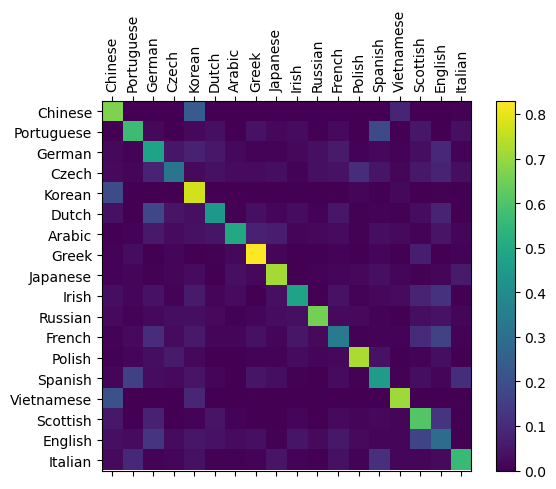


> Yuan
(-0.25) Chinese
(-1.67) Korean
(-3.72) Vietnamese

> Jackson
(-0.56) Scottish
(-0.95) English
(-4.47) Greek

> Satoshi
(-1.74) Italian
(-1.84) Greek
(-2.08) Portuguese


In [47]:
"""
Step 5. Evaluating the results
"""

def evaluate(line_tensor):
    rnn.hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output = rnn(line_tensor[i])

    return output

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

"""
Step 6. Running on User input
"""

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Yuan')
predict('Jackson')
predict('Satoshi')

('Irish', 9)
category = German / line = Autenburg
category = Chinese / line = Zhan
category = Dutch / line = Hautem
category = Korean / line = Chun
category = Polish / line = Chmiel
category = Italian / line = Ambrogi
category = Dutch / line = Haenraets
category = Chinese / line = Zhu
category = Greek / line = Papadelias
category = Japanese / line = Kikutake


/tmp/ipykernel_20612/3070653463.py:54: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484746364/work/torch/csrc/utils/python_arg_parser.cpp:1174.)
  p.data.add_(-learning_rate, p.grad.data)


5000 5% (0m 5s) 2.7000 Bello / Spanish ✗ (Italian)
10000 10% (0m 9s) 1.7972 Aswad / Arabic ✓
15000 15% (0m 13s) 0.3025 Nomikos / Greek ✓
20000 20% (0m 18s) 2.6602 Ruda / Spanish ✗ (Czech)
25000 25% (0m 22s) 3.5019 Sansone / Japanese ✗ (Italian)
30000 30% (0m 26s) 1.7323 Bach / Vietnamese ✓
35000 35% (0m 30s) 1.5536 Arechavaleta / Irish ✗ (Spanish)
40000 40% (0m 35s) 0.7653 Semick / Czech ✓
45000 45% (0m 39s) 2.1700 Phung / Korean ✗ (Vietnamese)
50000 50% (0m 43s) 0.5314 Ramsay / Scottish ✓
55000 55% (0m 48s) 1.1173 Campos / Greek ✗ (Portuguese)
60000 60% (0m 52s) 0.7721 Chau / Vietnamese ✓
65000 65% (0m 56s) 0.7094 Johnstone / Scottish ✓
70000 70% (1m 1s) 6.2436 Theohari / Japanese ✗ (Greek)
75000 75% (1m 6s) 3.1467 Nifterick / Czech ✗ (Dutch)
80000 80% (1m 10s) 0.4862 Phan / Vietnamese ✓
85000 85% (1m 15s) 0.3063 Vinh / Vietnamese ✓
90000 90% (1m 19s) 2.5010 Blanc / Scottish ✗ (French)
95000 95% (1m 23s) 2.3399 Cummings / Greek ✗ (English)
100000 100% (1m 28s) 2.6528 Kang / Chinese ✗ 

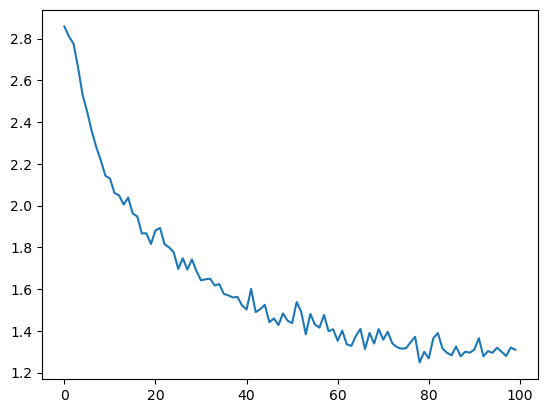

In [12]:
"""
Step 4. Training
"""

#  Before going into training we should make a few helper functions. The first is
#to interpret the output of the network, which we know to be a likelihood of each
#category. We can use Tensor.topk to get the index of the greatest value.
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))


#  We will also want a quick way to get a training example (a name and its language):
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

#  Now all it takes to train this network is show it a bunch of examples, have it
#make guesses, and tell it if it's wrong.
#  For the loss, nn.NLLLoss is appropriate since the last layer of the RNN is 
#nn.LogSoftmax.
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()


#  Now we just have to run with a bunch of examples. Since the train function returns
#both the output and loss we can print its guesses and also keep track of loss for
#plotting. Since there are 1000s of examples we print only every print_every examples,
#and take an average of the loss.
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


#  Plotting the historical loss from all_losses shows the network learning:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_20612/2731588864.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_20612/2731588864.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


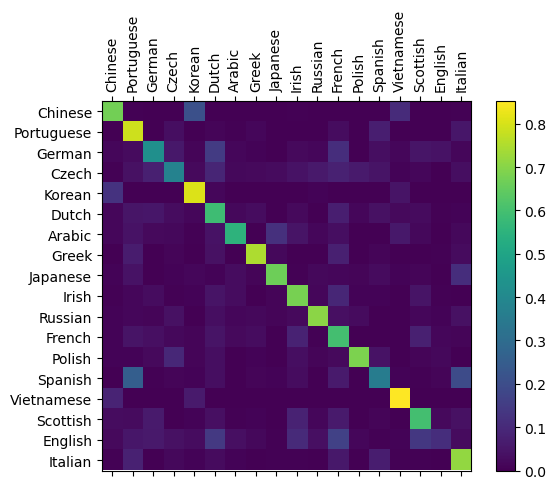

In [13]:
"""
Step 5. Evaluating the results
"""

#  To see how well the network performs on different categories, we will create a confusion
#matrix, indicating for every actual language (rows) which language the network guesses
#(columns). To calculate the confusion matrix a bunch of samples are run through the
#network with evaluate(), which is the same as train() minus the backprop.
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [14]:

"""
Step 5.1: Running on User input
"""
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Yuan')
predict('Jackson')
predict('Satoshi')


> Yuan
(-0.56) Chinese
(-1.06) Korean
(-3.83) Vietnamese

> Jackson
(-1.13) English
(-1.19) Scottish
(-2.26) Czech

> Satoshi
(-1.11) Italian
(-1.30) Japanese
(-2.31) Arabic


In [15]:
"""
Repeat the above steps with the LSTM model
"""

class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(LSTM,self).__init__()
        self.hidden_size = hidden_size

        self.LSTM = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=False,
        )
        self.linear = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.LogSoftmax(dim=1)
    def forward(self,x):
        lstm,_ = self.LSTM(x) 
        out = self.linear(lstm[-1, :, :])
        #output =self.softmax(out)
        return out

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)
#criterion = nn.NLLLoss()
criterion=nn.CrossEntropyLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train_lstm(category_tensor, line_tensor):
    lstm.zero_grad()

    #for i in range(line_tensor.size()[0]):
    output = lstm(line_tensor)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [16]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
lstm_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_lstm(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        lstm_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 2.9201 Moralez / English ✗ (Spanish)
10000 10% (0m 15s) 2.6043 Wyrick / Polish ✓
15000 15% (0m 24s) 2.9221 Ryoo / German ✗ (Korean)
20000 20% (0m 32s) 2.5726 Henriques / Greek ✗ (Portuguese)
25000 25% (0m 39s) 2.8244 Robson / Spanish ✗ (English)
30000 30% (0m 46s) 2.0415 Duong / Vietnamese ✓
35000 35% (0m 54s) 2.5849 Ochoa / Arabic ✗ (Spanish)
40000 40% (1m 1s) 1.8538 Winter / German ✓
45000 45% (1m 9s) 0.5599 Lutoshnikov / Russian ✓
50000 50% (1m 16s) 0.9807 Mui / Chinese ✓
55000 55% (1m 24s) 0.7983 Pechkovsky / Russian ✓
60000 60% (1m 31s) 0.9482 Nuallan / Irish ✓
65000 65% (1m 38s) 1.6506 Mustafa / Portuguese ✗ (Arabic)
70000 70% (1m 46s) 0.9063 Jing / Chinese ✓
75000 75% (1m 54s) 0.7682 Jo / Korean ✓
80000 80% (2m 1s) 0.5201 Tokudome / Japanese ✓
85000 85% (2m 8s) 2.6895 Mojjis / Greek ✗ (Czech)
90000 90% (2m 16s) 2.8190 Fattore / French ✗ (Italian)
95000 95% (2m 23s) 2.4653 Brahms / Portuguese ✗ (German)
100000 100% (2m 31s) 1.7271 Ngo / Korean ✗ (Vietnamese)


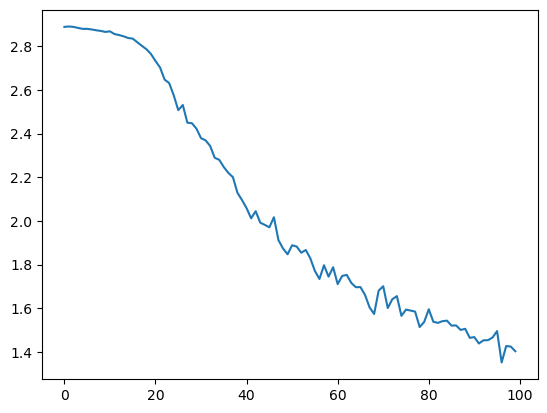

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(lstm_losses)

In [18]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = lstm(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Yuan')
predict('Jackson')
predict('Satoshi')


> Yuan
(5.04) Chinese
(4.35) Vietnamese
(4.29) Korean

> Jackson
(5.25) Scottish
(4.18) English
(3.68) Russian

> Satoshi
(6.84) Japanese
(5.23) Arabic
(4.32) Polish


In [23]:
import torch
import torch.nn as nn

class MomentumRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, momentum_coefficient, scaling_factor, dropout_rate=0.5):
        super(MomentumRNN, self).__init__()
        self.hidden_size = hidden_size
        self.momentum_coefficient = momentum_coefficient
        self.scaling_factor = scaling_factor

        self.U = nn.Linear(hidden_size, hidden_size)
        self.W = nn.Linear(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x, hidden, momentum):
        v = momentum * hidden + self.scaling_factor * self.W(x)
        hidden = self.activation(self.U(hidden) + self.dropout(v))  # Apply dropout
        output = self.linear(hidden)
        return output, hidden, v

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Define the parameters
n_hidden = 128
momentum_coefficient = 0.9
scaling_factor = 0.1

# Create an instance of the MomentumRNN
momentum_rnn = MomentumRNN(n_letters, n_hidden, n_categories, momentum_coefficient, scaling_factor)

In [24]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.SGD(momentum_rnn.parameters(), lr=learning_rate)

# Rest of your code...

# Within the train_momentum_rnn function
def train_momentum_rnn(category_tensor, line_tensor, hidden, momentum):
    momentum_rnn.zero_grad()
    loss = 0

    for i in range(line_tensor.size()[0]):
        output, hidden, momentum = momentum_rnn(line_tensor[i], hidden, momentum)
        loss += criterion(output, category_tensor)

    loss /= line_tensor.size()[0]  # Divide the loss by the sequence length

    optimizer.zero_grad()  # Zero out the gradients
    loss.backward(retain_graph=True)  # Perform backward pass with retain_graph=True
    optimizer.step()  # Update the parameters

    return output, loss.item(), hidden.detach().clone(), momentum.detach().clone()

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
momentum_rnn_losses = []

hidden = momentum_rnn.initHidden()
momentum = torch.zeros_like(hidden)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss, hidden, momentum = train_momentum_rnn(category_tensor, line_tensor, hidden, momentum)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        momentum_rnn_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 30s) 2.9658 Pereira / Japanese ✗ (Portuguese)
10000 10% (0m 58s) 2.9430 Sadowski / Greek ✗ (Polish)
15000 15% (1m 26s) 2.9312 Furnish / Italian ✗ (English)
20000 20% (1m 55s) 2.9322 Cho / French ✗ (Korean)
25000 25% (2m 24s) 2.8584 Parma / Greek ✗ (Italian)
30000 30% (2m 53s) 2.9531 Morrison / Vietnamese ✗ (Scottish)
35000 35% (3m 23s) 2.9779 O'Boyle / Chinese ✗ (Irish)
40000 40% (3m 54s) 3.0755 Conall / Greek ✗ (Irish)
45000 45% (4m 24s) 2.9544 Teshigahara / Spanish ✗ (Japanese)
50000 50% (4m 52s) 2.8476 Tselios / English ✗ (Greek)
55000 55% (5m 20s) 3.1508 Osladil / Russian ✗ (Czech)
60000 60% (5m 33s) 2.9004 Imatkulov / French ✗ (Russian)
65000 65% (5m 43s) 3.2770 Maroun / Russian ✗ (Arabic)
70000 70% (5m 53s) 2.9259 Kolman / Dutch ✗ (Czech)
75000 75% (6m 3s) 2.9763 Ceallach / Spanish ✗ (Irish)
80000 80% (6m 14s) 2.7794 Egr / Russian ✗ (Czech)
85000 85% (6m 24s) 3.0369 Kotsiopoulos / Arabic ✗ (Greek)
90000 90% (6m 34s) 2.7755 Ramsay / German ✗ (Scottish)
95000 95% (6m 44

In [34]:
import torch
import torch.nn as nn
import string
import random

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        output, _ = self.lstm(input)
        output = self.fc(output[-1])  # Use the last output sequence
        return output

# Prepare the data
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Define categories and names
categories = ['English', 'French', 'Spanish']
names = {
    'English': ['Smith', 'Johnson', 'Brown'],
    'French': ['Dupont', 'Leblanc', 'Lefebvre'],
    'Spanish': ['Garcia', 'Lopez', 'Rodriguez']
}

# Convert names to tensors
category_lines = {}
for category, name_list in names.items():
    lines = [lineToTensor(name) for name in name_list]
    category_lines[category] = lines

# Define the LSTM model and criterion
hidden_size = 128
output_size = len(categories)
lstm = LSTM(n_letters, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()

# Training
learning_rate = 0.005
optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

def lineToTensor(line):
    tensor = torch.zeros(len(line), n_letters)
    for li, letter in enumerate(line):
        tensor[li][letterToIndex(letter)] = 1
    return tensor

def letterToIndex(letter):
    return all_letters.find(letter)


def line_tensorToName(line_tensor):
    name = ""
    for tensor in line_tensor:
        _, idx = tensor.max(dim=1)  # Fix the dimension for finding the max value
        letter = all_letters[idx.item()]
        name += letter
    return name

# Within the train function
def train(category_tensor, line_tensor):
    hidden = torch.zeros(1, 1, hidden_size)
    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output = lstm(line_tensor[i].unsqueeze(0))
        hidden = output

    # Modify the category_tensor shape
    category_tensor = category_tensor.squeeze()

    loss = criterion(output.squeeze(), category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()



n_iters = 10000
print_every = 500
plot_every = 100
current_loss = 0

for iter in range(1, n_iters + 1):
    category = random.choice(categories)
    line_tensor = random.choice(category_lines[category])
    category_tensor = torch.tensor([categories.index(category)], dtype=torch.long)

    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess = categories[torch.argmax(output)]
        correct = '✓' if guess == category else '✗'
        print(f'{iter} {iter / n_iters * 100}% Loss: {loss:.4f} Name: {line_tensorToName(line_tensor)} Guess: {guess} {correct}')

    if iter % plot_every == 0:
        current_loss /= plot_every
        # TODO: Plot the loss

# Prediction
def predict(input_line):
    with torch.no_grad():
        input_tensor = lineToTensor(input_line)
        output = lstm(input_tensor)
        top_category = categories[torch.argmax(output)]
        return top_category

# Example prediction
input_name = "Gomez"
predicted_category = predict(input_name)
print(f"Input: {input_name}, Predicted Category: {predicted_category}")


500 5.0% Loss: 1.1052 Name: Johnson Guess: Spanish ✗
1000 10.0% Loss: 1.1200 Name: Dupont Guess: Spanish ✗
1500 15.0% Loss: 1.0750 Name: Smith Guess: English ✓
2000 20.0% Loss: 1.0077 Name: Rodriguez Guess: Spanish ✓
2500 25.0% Loss: 1.0359 Name: Dupont Guess: French ✓
3000 30.0% Loss: 1.0133 Name: Johnson Guess: English ✓
3500 35.0% Loss: 0.9702 Name: Garcia Guess: Spanish ✓
4000 40.0% Loss: 1.0531 Name: Leblanc Guess: French ✓
4500 45.0% Loss: 0.7639 Name: Johnson Guess: English ✓
5000 50.0% Loss: 0.9208 Name: Dupont Guess: French ✓
5500 55.00000000000001% Loss: 0.7798 Name: Smith Guess: English ✓
6000 60.0% Loss: 0.5349 Name: Rodriguez Guess: Spanish ✓
6500 65.0% Loss: 0.4915 Name: Johnson Guess: English ✓
7000 70.0% Loss: 0.5561 Name: Leblanc Guess: French ✓
7500 75.0% Loss: 0.5740 Name: Smith Guess: English ✓
8000 80.0% Loss: 0.4307 Name: Leblanc Guess: French ✓
8500 85.0% Loss: 0.2268 Name: Johnson Guess: English ✓
9000 90.0% Loss: 0.3989 Name: Smith Guess: English ✓
9500 95.0% L

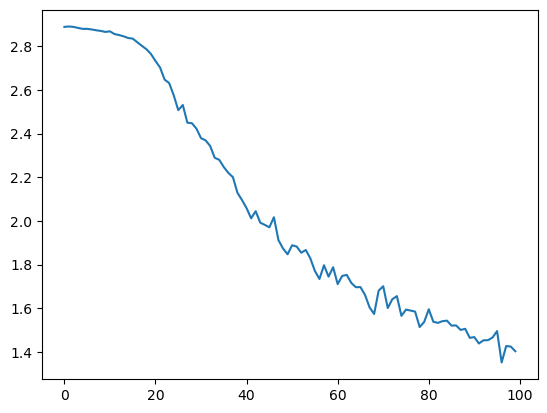

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(lstm_losses)

In [39]:

def predict(input_line):
    with torch.no_grad():
        input_tensor = lineToTensor(input_line)
        output = lstm(input_tensor)
        top_category = categories[torch.argmax(output)]
        return top_category

# Example prediction
input_name = "Gomez"
predicted_category = predict(input_name)
print(f"Input: {input_name}, Predicted Category: {predicted_category}")
# predict('Yuan')
# predict('Jackson')
# predict('Satoshi')

Input: Gomez, Predicted Category: Spanish


In [40]:
import torch.nn as nn

class MomentumRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, momentum_mu, momentum_s):
        super(MomentumRNN, self).__init__()

        self.hidden_size = hidden_size
        self.momentum_mu = momentum_mu
        self.momentum_s = momentum_s

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, velocity):
        combined = torch.cat((input, hidden), 1)
        velocity = self.momentum_mu * velocity + self.momentum_s * self.i2h.weight @ input
        hidden = self.i2h(combined) + velocity
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden, velocity

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    def initVelocity(self):
        return torch.zeros(1, self.hidden_size)


In [41]:
n_hidden = 128
momentum_mu = 0.9  
momentum_s = 0.1 
momentum_rnn = MomentumRNN(n_letters, n_hidden, n_categories, momentum_mu, momentum_s)

# Training
def train(category_tensor, line_tensor, hidden, velocity):
    momentum_rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden, velocity = momentum_rnn(line_tensor[i], hidden, velocity)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Update parameters with momentum
    for p in momentum_rnn.parameters():
        if p.requires_grad:
            p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item(), hidden, velocity

# Evaluation
def evaluate(line_tensor, hidden, velocity):
    for i in range(line_tensor.size()[0]):
        output, hidden, velocity = momentum_rnn(line_tensor[i], hidden, velocity)

    return output, hidden, velocity

# Training loop
hidden = momentum_rnn.initHidden()
velocity = momentum_rnn.initVelocity()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss, hidden, velocity = train(category_tensor, line_tensor, hidden, velocity)


KeyError: 'Czech'